## Expectation Maximisation with Python : Coin Toss 

This notebook implements the example, I consider a classic for understanding Expectation Maximisation.

See: http://www.nature.com/nbt/journal/v26/n8/full/nbt1406.html


Notations:


\begin{align*}
\theta_A  &= \text{Probability of a Heads showing up given the coin tossed is A}\\
\theta_B  &= \text{Probability of a Heads showing up given the coin tossed is B}\\
\end{align*}


In [3]:
%matplotlib notebook
from __future__ import division
from collections import OrderedDict
from scipy.stats import binom as binomial
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from ipywidgets import StaticInteract, RangeWidget
import pandas as pd
from IPython.display import display, Image
from scipy.spatial.distance import euclidean
from sympy import init_printing, symbols, Eq
init_printing()

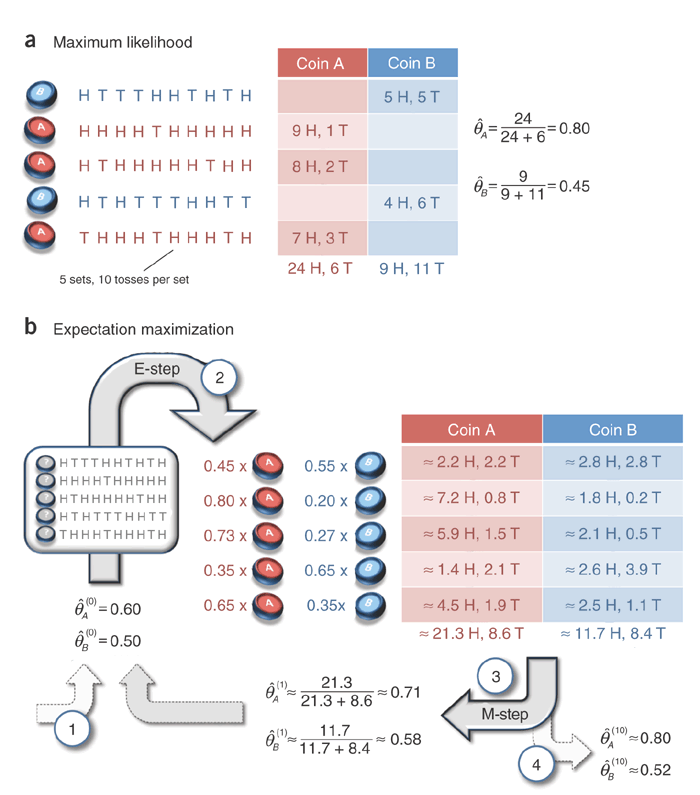

In [4]:
Image('images/nbt1406-F1.png')

In [5]:
coin_toss = []
coin_toss.append('H T T T H H T H T H'.split())
coin_toss.append('H H H H T H H H H H'.split())
coin_toss.append('H T H H H H H T H H'.split())
coin_toss.append('H T H T T T H H T T'.split())
coin_toss.append('T H H H T H H H T H'.split())

In [7]:
columns = range(1,11)
df = pd.DataFrame(coin_toss, index=None, columns=columns)
df.index.rename('Toss')

Int64Index([0, 1, 2, 3, 4], dtype='int64', name=u'Toss')

Our configuration looks like this:

In [8]:
df

,1,2,3,4,5,6,7,8,9,10
0,H,T,T,T,H,H,T,H,T,H
1,H,H,H,H,T,H,H,H,H,H
2,H,T,H,H,H,H,H,T,H,H
3,H,T,H,T,T,T,H,H,T,T
4,T,H,H,H,T,H,H,H,T,H


## Case 1: Identity of coin being tossed known

If the identity of the coin being tossed is known and is `observed = ['B', 'A', 'A', 'B', 'A']` it is not so difficult to calculate the corresponding values of $\theta_A$ and $\theta_B$:

$$
\theta_A = \frac{\text{Total Heads when coin tossed is A}}{\text{Total tosses for coin A}}
$$


$$
\theta_B = \frac{\text{Total Heads when coin tossed is B}}{\text{Total tosses for coin B}}
$$


In [9]:
thetaA, thetaB = symbols('theta_A theta_B')
a,b = thetaA, thetaB # Hack to display

In [10]:
## Observed Case

observed = ['B', 'A', 'A', 'B', 'A']
index_A = [i for i,x in enumerate(observed) if x=='A']
index_B = [i for i,x in enumerate(observed) if x=='B']

total_tosses = df.size

A_tosses = df.iloc[index_A].unstack()
B_tosses = df.iloc[index_B].unstack()

A_heads = A_tosses.value_counts()['H']
B_heads = B_tosses.value_counts()['H']

theta_A = A_heads/A_tosses.size
theta_B = B_heads/B_tosses.size

In [11]:
(a, theta_A)

In [12]:
(b, theta_B)

## Case 2 Identity of coin being tossed is unknown

When the identity of coin being tossed is unknwon we rely on Expectation Maximisation to give us the estimates of $\theta_A$ and $\theta_B$. We start with an initial value of $\theta_A, \theta_B$ and then given the observed data (the 50 coin tosses) run the 'E-step' calculating the probability of coin $A$ or $B$ being used for a series of tosses(Remember each set of 10 coin tosses is done using 

In [14]:
thetaA = 0.6
thetaB = 0.5

def em(theta_old):
    row_prob = []
    ## Expectation
    for row in coin_toss:
        count_heads = row.count('H')
        p_a = binomial.pmf(count_heads, len(row), theta_old['A'])
        p_b = binomial.pmf(count_heads, len(row), theta_old['B'])
        p_t = p_a+p_b
        p_a = p_a/p_t
        p_b = p_b/p_t
        row_prob.append({'A': p_a, 'B': p_b, 'count_heads': count_heads, 'total_tosses': len(row)})
        
    ## Maximisation
    new_coin_toss = []
    for row in row_prob:
        total_tosses = row['total_tosses']
        total_heads = row['count_heads']
        A_heads = row['A']*total_heads
        A_tails = row['A']*(total_tosses-total_heads)
        B_heads = row['B']*total_heads
        B_tails = row['B']*(total_tosses-total_heads)
        new_coin_toss.append([A_heads, A_tails, B_heads, B_tails])
    df = pd.DataFrame(new_coin_toss, columns=['A Heads', 'A Tails', 'B Heads', 'B Tails'])
    new_pa = df['A Heads'].sum()/(df['A Heads'].sum()+df['A Tails'].sum())
    new_pb = df['B Heads'].sum()/(df['B Heads'].sum()+df['B Tails'].sum())
    new_theta = OrderedDict({'A': new_pa, 'B': new_pb})
    display(df)
    return new_theta

theta = OrderedDict({'A': thetaA, 'B': thetaB})


In [15]:
theta_new = OrderedDict()
max_iterations = 10000
iterations = 0
diff = 1
tolerance = 1e-6
while (iterations < max_iterations) and (diff>tolerance):
    new_theta = em(theta)
    diff = euclidean(new_theta.values(), theta.values())
    theta = new_theta

,A Heads,A Tails,B Heads,B Tails
0,2.245745,2.245745,2.754255,2.754255
1,7.244870,0.804986,1.755130,0.195014
2,5.867737,1.466934,2.132263,0.533066
3,1.408625,2.112937,2.591375,3.887063
4,4.530506,1.941645,2.469494,1.058355


,A Heads,A Tails,B Heads,B Tails
0,1.479097,1.479097,3.520903,3.520903
1,7.303594,0.811510,1.696406,0.188490
2,5.651376,1.412844,2.348624,0.587156
3,0.760578,1.140867,3.239422,4.859133
4,4.014738,1.720602,2.985262,1.279398


,A Heads,A Tails,B Heads,B Tails
0,1.087962,1.087962,3.912038,3.912038
1,7.828637,0.869849,1.171363,0.130151
2,6.009233,1.502308,1.990767,0.497692
3,0.446362,0.669544,3.553638,5.330456
4,4.038084,1.730607,2.961916,1.269393


,A Heads,A Tails,B Heads,B Tails
0,0.808513,0.808513,4.191487,4.191487
1,8.216144,0.912905,0.783856,0.087095
2,6.354109,1.588527,1.645891,0.411473
3,0.265334,0.398001,3.734666,5.601999
4,4.109732,1.761314,2.890268,1.238686


,A Heads,A Tails,B Heads,B Tails
0,0.645102,0.645102,4.354898,4.354898
1,8.418405,0.935378,0.581595,0.064622
2,6.572406,1.643101,1.427594,0.356899
3,0.179981,0.269971,3.820019,5.730029
4,4.159435,1.782615,2.840565,1.217385


,A Heads,A Tails,B Heads,B Tails
0,0.567711,0.567711,4.432289,4.432289
1,8.507517,0.945280,0.492483,0.054720
2,6.681854,1.670464,1.318146,0.329536
3,0.144896,0.217344,3.855104,5.782656
4,4.185923,1.793967,2.814077,1.206033


,A Heads,A Tails,B Heads,B Tails
0,0.535440,0.535440,4.464560,4.464560
1,8.544022,0.949336,0.455978,0.050664
2,6.730149,1.682537,1.269851,0.317463
3,0.131238,0.196856,3.868762,5.803144
4,4.198972,1.799559,2.801028,1.200441


,A Heads,A Tails,B Heads,B Tails
0,0.522786,0.522786,4.477214,4.477214
1,8.558587,0.950954,0.441413,0.049046
2,6.750249,1.687562,1.249751,0.312438
3,0.126013,0.189019,3.873987,5.810981
4,4.205202,1.802230,2.794798,1.197770


,A Heads,A Tails,B Heads,B Tails
0,0.517957,0.517957,4.482043,4.482043
1,8.564351,0.951595,0.435649,0.048405
2,6.758425,1.689606,1.241575,0.310394
3,0.124026,0.186039,3.875974,5.813961
4,4.208106,1.803474,2.791894,1.196526


,A Heads,A Tails,B Heads,B Tails
0,0.516135,0.516135,4.483865,4.483865
1,8.566629,0.951848,0.433371,0.048152
2,6.761725,1.690431,1.238275,0.309569
3,0.123272,0.184909,3.876728,5.815091
4,4.209430,1.804042,2.790570,1.195958


,A Heads,A Tails,B Heads,B Tails
0,0.515451,0.515451,4.484549,4.484549
1,8.567530,0.951948,0.432470,0.048052
2,6.763053,1.690763,1.236947,0.309237
3,0.122987,0.184480,3.877013,5.815520
4,4.210025,1.804296,2.789975,1.195704


,A Heads,A Tails,B Heads,B Tails
0,0.515196,0.515196,4.484804,4.484804
1,8.567887,0.951987,0.432113,0.048013
2,6.763588,1.690897,1.236412,0.309103
3,0.122879,0.184318,3.877121,5.815682
4,4.210288,1.804409,2.789712,1.195591


,A Heads,A Tails,B Heads,B Tails
0,0.515100,0.515100,4.484900,4.484900
1,8.568028,0.952003,0.431972,0.047997
2,6.763804,1.690951,1.236196,0.309049
3,0.122838,0.184256,3.877162,5.815744
4,4.210403,1.804458,2.789597,1.195542


,A Heads,A Tails,B Heads,B Tails
0,0.515065,0.515065,4.484935,4.484935
1,8.568084,0.952009,0.431916,0.047991
2,6.763891,1.690973,1.236109,0.309027
3,0.122822,0.184233,3.877178,5.815767
4,4.210453,1.804480,2.789547,1.195520


,A Heads,A Tails,B Heads,B Tails
0,0.515051,0.515051,4.484949,4.484949
1,8.568106,0.952012,0.431894,0.047988
2,6.763926,1.690982,1.236074,0.309018
3,0.122816,0.184224,3.877184,5.815776
4,4.210474,1.804489,2.789526,1.195511


,A Heads,A Tails,B Heads,B Tails
0,0.515046,0.515046,4.484954,4.484954
1,8.568115,0.952013,0.431885,0.047987
2,6.763940,1.690985,1.236060,0.309015
3,0.122814,0.184221,3.877186,5.815779
4,4.210483,1.804493,2.789517,1.195507


In [59]:
(a, new_theta['A'])

In [60]:
(b, new_theta['B'])